In [1]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential

In [20]:
IMAGE_SIZE = 630
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 7


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "BrainSamples",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)



Found 1361 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['no', 'pred', 'yes']

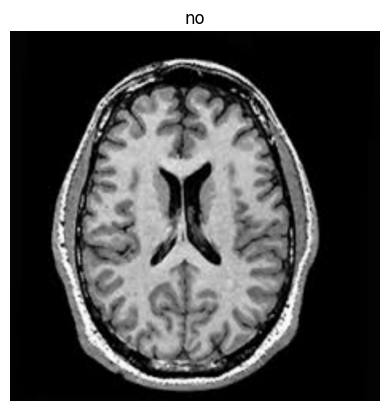

In [5]:
for image_batch , label_batch in dataset.take(1):
   
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [6]:
len(dataset)

43

80% ==>training
20% ==>10%validation , 10%test

In [7]:
train_size = 0.8
len(dataset)*train_size

34.4

In [8]:
train_DS = dataset.take(77)
test_DS = dataset.skip(77)

In [9]:
val_DS = test_DS.take(9)
test_DS = test_DS.skip(9)

In [10]:
def get_dataset_partition_tf(ds, train_split=0.8 , val_split=0.1 , test_split=0.1 , shuffle = True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=8)
        
        train_size = int(train_split*ds_size)
        val_size = int(val_split*ds_size)
        
        train_DS = ds.take(train_size)
        val_DS = ds.skip(train_size).take(val_size)
        test_DS =ds.skip(train_size).skip(val_size)
        
    return train_DS, val_DS, test_DS

In [11]:
train_DS, val_DS, test_DS = get_dataset_partition_tf(dataset)


In [12]:
len(train_DS), len(val_DS),len(test_DS)

(34, 4, 5)

In [13]:
train_DS = train_DS.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_DS = val_DS.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_DS = test_DS.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
   layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 630, 630, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 630, 630, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 628, 628, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (32, 314, 314, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 312, 312, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 156, 156, 64)        0         
 g2D)                                                 

In [18]:
model.compile(
optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
 history = model.fit( train_DS, 
                     epochs=EPOCHS, 
                     batch_size=BATCH_SIZE, 
                     verbose=1, 
                     validation_data=val_DS
)



Epoch 1/7
34/34 [==============================] - 2196s 64s/step - loss: 0.4723 - accuracy: 0.8226 - val_loss: 0.4278 - val_accuracy: 0.8203
Epoch 2/7
34/34 [==============================] - 1548s 45s/step - loss: 0.4481 - accuracy: 0.8364 - val_loss: 0.4129 - val_accuracy: 0.8281
Epoch 3/7
34/34 [==============================] - 1520s 45s/step - loss: 0.4443 - accuracy: 0.8392 - val_loss: 0.3985 - val_accuracy: 0.8594
Epoch 4/7
34/34 [==============================] - 1641s 48s/step - loss: 0.4393 - accuracy: 0.8401 - val_loss: 0.4158 - val_accuracy: 0.8359
Epoch 5/7
34/34 [==============================] - 6079s 183s/step - loss: 0.4437 - accuracy: 0.8336 - val_loss: 0.3926 - val_accuracy: 0.8438
Epoch 6/7
34/34 [==============================] - 1439s 42s/step - loss: 0.4174 - accuracy: 0.8566 - val_loss: 0.3883 - val_accuracy: 0.8359
Epoch 7/7
34/34 [==============================] - 1362s 40s/step - loss: 0.4119 - accuracy: 0.8566 - val_loss: 0.3475 - val_accuracy: 0.8438


In [22]:
scores = model.evaluate(test_DS)

5/5 [==============================] - 100s 10s/step - loss: 0.4368 - accuracy: 0.8438


In [23]:
scores

[0.43676432967185974, 0.84375]

In [24]:
history


In [25]:
history.params

{'verbose': 1, 'epochs': 7, 'steps': 34}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
len(history.history['accuracy'])

7

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss =history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

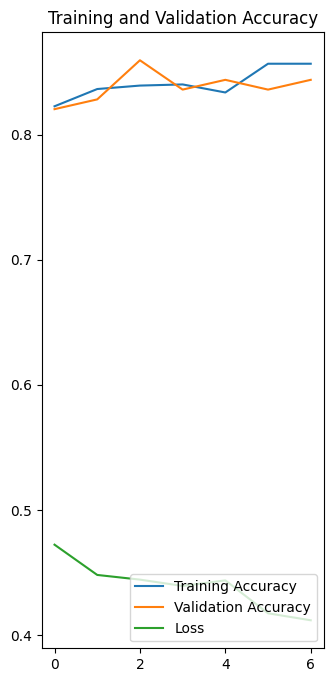

In [29]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.plot(range(EPOCHS), loss, label='Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

actual_label: yes
1/1 [==============================] - 9s 9s/step
predicted_label: yes


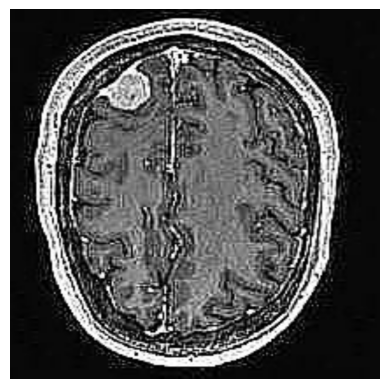

In [30]:

for images_batch, labels_batch in test_DS.take(1):

    first_image = image_batch[21].numpy().astype('uint8')
    first_label = labels_batch[21].numpy().astype('uint8')
    plt.imshow(first_image)
    print("actual_label:",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted_label:",class_names[np.argmax(batch_prediction[21])])
    plt.axis("off")

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    accuracy = round(100*(np.max(predictions[0])),2)
    return predicted_class, accuracy

1/1 [==============================] - 0s 167ms/step


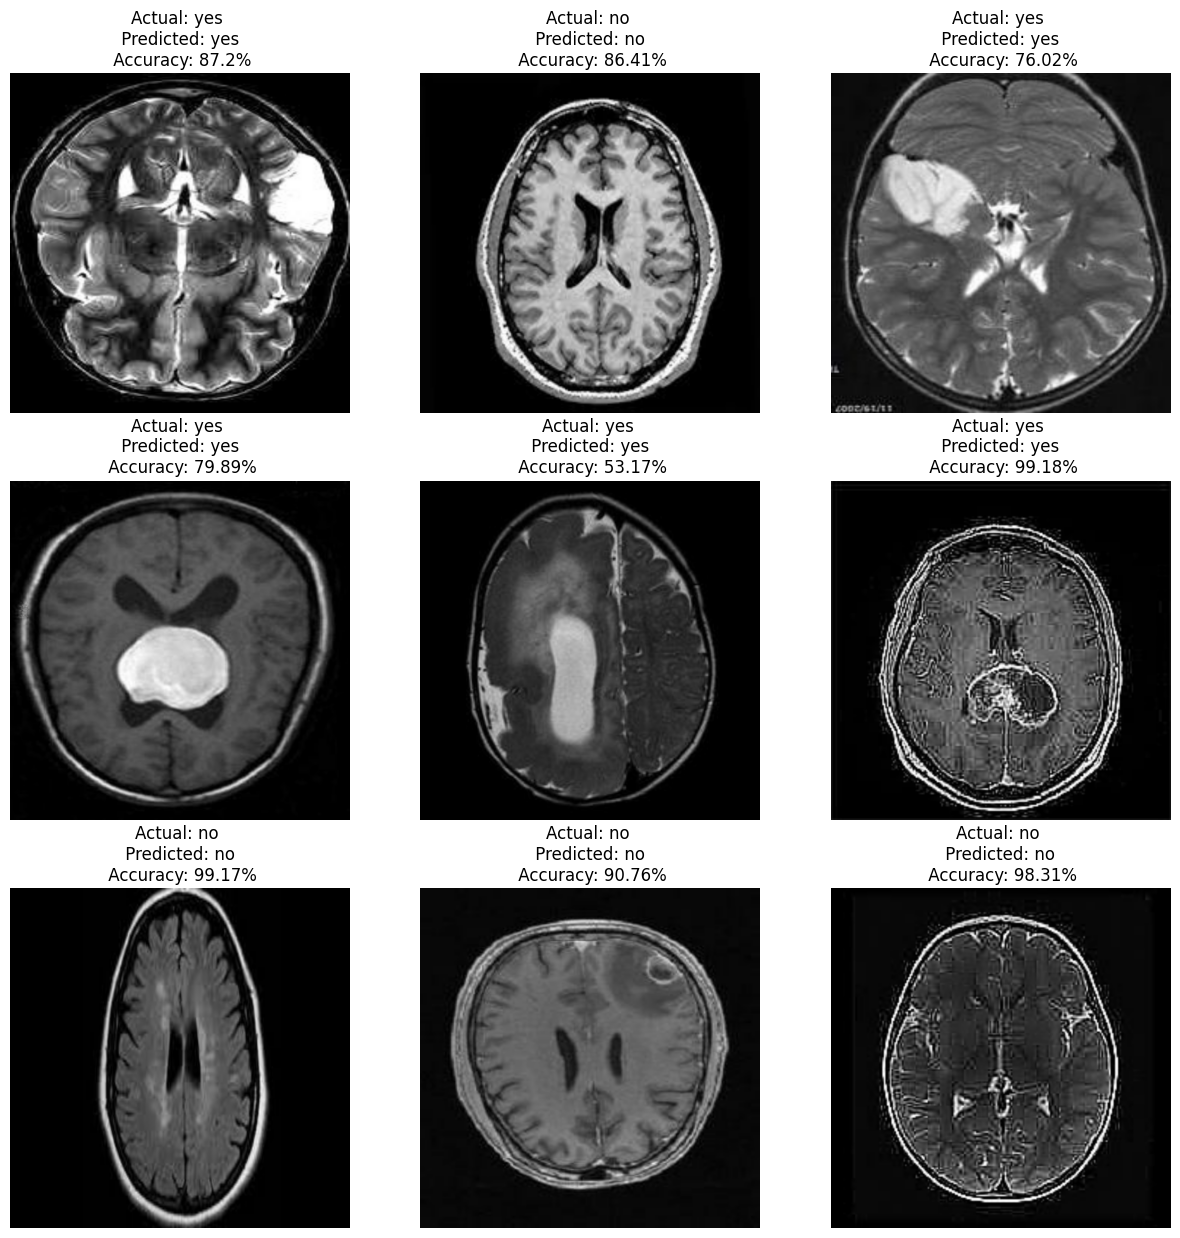

In [32]:
plt.figure(figsize=(15,15))
for images, labels in test_DS.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , accuracy = predict(model ,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Accuracy: {accuracy}%")
        plt.axis("off")

In [ ]:
model_version = 1.4
model.save(f"../saved_models/{model_version}")

NameError: name 'model' is not defined